In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from IPython.display import display, FileLink, FileLinks, HTML
from clawpack.visclaw import animation_tools
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


** Applying Forward Euler to time and Center to space**

$$
    \frac{U_j^{n+1} - U_j^n}{\Delta t} = -6 U_j^n \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} - \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3}
$$

Since we cannot apply the von Neumann analysis directly to KdV equation, we first estimate stability criterion by looking at the linear part of it (because $u_{xxx}$ is dominate part):

$$
    u_t = - u_{xxx}
$$

Applying forward Euler finite difference to time and center finite difference to space

$$
    U_j^{n+1} = U_j^n + \frac{\Delta t}{\Delta x^3} \left( U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n \right)
$$    

Using $U_j^n = g(\xi)^n e^{i \xi j \Delta x}$

$$
    g(\xi) = 1 + \frac{\Delta t}{\Delta x^3} \left( e^{2i \xi \Delta x} - 2 e^{i \xi \Delta x} + 2 e^{-i \xi \Delta x} - e^{-2i \xi \Delta x} \right)
$$

Since we want $|g(\xi)| < 1$, so

$$
    -1 < |g(\xi)|^2 = 1 - \left( \frac{\Delta t}{\Delta x^3} \left(2 \sin(2 \xi \Delta x) - 4 \sin(\xi \Delta x)  \right)\right)^2 < 1
$$

$$
    \Delta t < \frac{\Delta x^3}{\sin(2 \xi \Delta x) - 2 \sin(\xi \Delta x)}
$$

When $\xi \Delta x = \frac 4 3 \pi$, $\sin(2 \xi \Delta x) - 2 \sin(\xi \Delta x)$ attains maximum value $\frac{3\sqrt{3}}{2}$. Thus,

$$
    \Delta t < \frac{2\Delta x^3}{3 \sqrt{3}}
$$



In [5]:
def first(N, dt, f, t_final):
    x = np.linspace(-20,20,N)
    dx = x[1] - x[0]
    c_1 = 2.
    u = f(x)

    t_range = np.arange(0., t_final, dt)
    n = len(t_range)
    m = len(u)

    nplt = floor((1./20)/dt) 

    c1 = dt/dx
    c2 = dt/(dx**3)

    U = np.empty((n,m))
    U[0,:] = u

    figs = []
    for k in xrange(n-1):
        U[k+1,0] = 0#U[k,0] - 3.*c1*U[k,0]*(U[k,1] - U[k,-1]) - 0.5 * c2*(U[k,2] - 2*U[k,1] + 2.*U[k,-1] - U[k,-2])
        U[k+1,1] = 0#U[k,1] - 3.*c1*U[k,1]*(U[k,2] - U[k,0]) - 0.5 * c2*(U[k,3] - 2*U[k,2] + 2.*U[k,0] - U[k,-1])
        U[k+1,-1] = U[k+1,0]
        U[k+1,-2] = U[k+1,1]

        for i in xrange(2,m-2):
            U[k+1,i] = U[k,i] - 3.*c1*U[k,i]*(U[k,i+1] - U[k,i-1]) - 0.5* c2*(U[k,i+2] - 2*U[k,i+1] + 2.*U[k,i-1] - U[k,i-2])

    return U, x, nplt
    


In [7]:
figs = []
dt = 0.0001
figs = []
c_1 = 2.
u_ini_single = lambda x: 0.5 * c_1 * (np.cosh(np.sqrt(c_1)*(x+8)/2.))**(-2)
U, x, nplt = first(N=256, dt=dt, f=u_ini_single, t_final=2.)
for k in xrange(U.shape[0]):
    if k % nplt == 0:
        fig = figure()
        plt.plot(x, U[k,:])
        plt.xlim([-20., 20.])
        plt.ylim([-0.2, 1.1])
        plt.title('FTCS under $ \Delta t = $%s' %dt)
        figs.append(fig)
        close(fig)
images = animation_tools.make_images(figs)
animation_tools.JSAnimate_images(images)

/Users/zengfanchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/zengfanchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
figs = []
c_1 = 2.
c_2 = 4.
u_ini_double = lambda x: 0.5*c_1*(np.cosh(np.sqrt(c_1)*(x)/2.))**(-2) + 0.5*c_2*(np.cosh(np.sqrt(c_2)*(x+8)/2.))**(-2)
dt = 0.0001
U, x, nplt = first(N=256, dt=dt, f=u_ini_double, t_final=2.)
for k in xrange(U.shape[0]):
    if k % nplt == 0:
        fig = figure()
        plt.plot(x, U[k,:])
        plt.xlim([-20., 20.])
        plt.ylim([-0.2, 2.1])
        plt.title('FTCS under $ \Delta t = $%s' %dt)
        figs.append(fig)
        close(fig)
images = animation_tools.make_images(figs)
animation_tools.JSAnimate_images(images)

/Users/zengfanchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/zengfanchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars


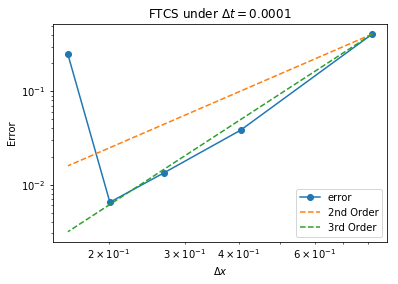

In [119]:
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
error_FTCS, delta_x = [], []
c_1 = 2.
dt = 0.0001
t_real = 2.
t_range = np.arange(0., 1., dt)

for N in [50, 100, 150, 200, 250]:
    U, x, nplt = first(N, dt)
    
    dx = x[1] - x[0]
    delta_x.append(dx)
    u_true = 0.5 * c_1 * (np.cosh(np.sqrt(c_1)*(x+8 - t_real)/2.))**(-2)
    error_FTCS.append(np.linalg.norm(dx * (U[-1, :] - u_true)))
 
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, error_FTCS, '-o', label = 'error')
axes.loglog(delta_x, order_C(delta_x[0], error_FTCS[0], 2.0) * np.array(delta_x)**2.0, '--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error_FTCS[0], 3.0) * np.array(delta_x)**3.0, '--', label="3rd Order")
axes.legend()
axes.set_xlabel('$ \Delta x$')
axes.set_ylabel('Error')
axes.set_title('FTCS under $ \Delta t = $%s' %dt)

**Trancation error analysis for FTCS**

$$
    \begin{aligned}
    \frac{U_j^{n+1} - U_j^n}{\Delta t} &= u_t + \mathcal{o}(\Delta t) \\
    6 U_j^n \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} &= 6 u (u_x + \mathcal{o}(\Delta x^2)) =  6 uu_x + \mathcal{o}(\Delta x^2) \\ 
    \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3} &= u_{xxx} + \mathcal{o}(\Delta x^2)
    \end{aligned}
$$

Thus,

$$
    \begin{aligned}
    &\frac{U_j^{n+1} - U_j^n}{\Delta t} + 6 U_j^n \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} + \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3} - ( u_t + 6uu_x + u_{xxx}) \\
    &= u_t + \mathcal{o}(\Delta t) + 6 uu_x + \mathcal{o}(\Delta x^2) + u_{xxx} + \mathcal{o}(\Delta x^2) - ( u_t + 6uu_x + u_{xxx}) \\
    &= \mathcal{o}(\Delta x^2) + \mathcal{o}(\Delta t)
    \end{aligned}
$$

Notice that $\Delta t < \frac{2\Delta x^3}{3 \sqrt{3}}$ from von Neumann analysis

$$
    \mathcal{o}(\Delta t) = \mathcal{o}(\Delta x^3) < \mathcal{o}(\Delta x^2)
$$

Therefore, the trancation error will be $$\epsilon_t = \mathcal{o}(\Delta x^2)$$

## This is the two possible reason that FTCS is not stable:

1. **Modified equation for FTCS**

Suppose $u = U_j^n$

$$
    \frac{U_j^{n+1} - U_j^n}{\Delta t} = u_t + \frac{\Delta t}{2} u_{tt} + \mathcal{o}(\Delta t^2)
$$

$$
    6 U_j^n \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} = 6 u (u_x + \frac{\Delta x^2}{6} u_{xxx} + \mathcal{o}(\Delta x^4)
$$

$$
    \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3} = u_{xxx} + \frac{\Delta x^2}{4} u_{xxxxx} + \mathcal{o}(\Delta x^4)
$$

Notice that

$$
    \begin{aligned}
    u_t &= -6uu_x - u_{xxx} \\
    u_{tt} &= -6u_tu_x - 6uu_{xt} - u_{xxxt} \\
    &= 36uu_x^2 + 6u_xu_{xxx} + 36uu_xu_{xx} + 6uu_{xxxx} + 6u_{xxx}u_{xxxx} + 6u_{xxxxxx}
    \end{aligned}
$$

Plug all into FTCS method,

$$
    u_t + \frac{\Delta t}{2} (36uu_x^2 + 6u_xu_{xxx} + 36uu_xu_{xx} + 6uu_{xxxx} + 6u_{xxx}u_{xxxx} + 6u_{xxxxxx}) + \mathcal{o}(\Delta t^2) = -6 u (u_x + \frac{\Delta x^2}{6} u_{xxx} - u_{xxx} + \frac{\Delta x^2}{4} u_{xxxxx} + \mathcal{o}(\Delta x^4))
$$

which leads to 

$$
    u_t = - 6uu_x(1 + 3\Delta tu_x + 3\Delta t u_{xx}) - (1 - u\Delta x^2 - 3\Delta tu_x + 3 \Delta t u_{xxxx}) u_{xxx} - (\frac{1}{4} \Delta x^2 u_{xxxxx} + 3\Delta tuu_{xxxx} + 3\Delta tu_{xxxxxx} ) + (\mathcal{o}(\Delta t^2) + \mathcal{o}(\Delta x^4))
$$

From the von Neumann analysis above, we know that $\Delta t < \frac{2\Delta x^3}{3 \sqrt{3}}$, **which means that $\Delta t$ can be ignored compared with $\Delta x^2$**. Thus, the modified equation of FTCS is

$$
    u_t = -6uu_x - (1 - u\Delta x^2) u_{xxx} - \frac{1}{4} \Delta x^2 u_{xxxxx} + \mathcal{o}(\Delta x^4)
$$

> From the modified equation, we know that the real PDE which FTCS is applied to contain the $u \Delta x^2 u_{xxx}$ and $-\frac 1 4 u_{xxxxx}$, which lead to unexpected error accumulation

2  **General linear stability analysis for method of Forward Euler to time and Center to space (explicit and implicit)**

$$
    \frac{U_j^{n+1} - U_j^n}{\Delta t} = -6 U_j^n \frac{(1 - \theta) (U_{j+1}^n - U_{j-1}^n) + \theta (U_{j+1}^{n+1} - U_{j-1}^{n+1})}{2 \Delta x} - \frac{(1 - \theta) (U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n) + \theta (U_{j+2}^{n+1} - 2 U_{j+1}^{n+1} + 2 U_{j-1}^{n+1} - U_{j-2}^{n+1})}{2 \Delta x^3}
$$

Using Von Neumann stability analysis $U_j^n = g(\xi)^n e^{i \xi j \Delta x}$

$$
    g(\xi) = 1 - \frac{3 \Delta t}{\Delta x} U_j^n \left[ 2 \theta i g(\xi) \sin(\xi \Delta  x) + 2 (1 - \theta) i \sin(\xi \theta) \right] - \frac{\Delta t}{2 \Delta x^3} \left\{ 2 \theta i g(\xi) [\sin(2\xi \Delta x) - 2 \sin(\xi \Delta x)] + 2 (1-\theta) i [\sin(2\xi \Delta x) - 2 \sin(\xi \Delta x)] \right\}
$$

For simplificaition, suppose $A = \sin(\xi \Delta  x)$ and $B = \sin(2\xi \Delta x) - 2 \sin(\xi \Delta x)$

$$
    g(\xi) = 1 - \frac{3 \Delta t}{\Delta x} U_j^n \left[ 2 \theta i g(\xi) A + 2 (1 - \theta) i A \right] - \frac{\Delta t}{2 \Delta x^3} \left[ 2 \theta i g(\xi) B + 2 (1-\theta) i B \right]
$$

$$
    g(\xi) [1 - \frac{6\Delta t}{\Delta x} U_j^n \theta i A - \frac{\Delta t}{\Delta x^3} \theta i B] = 1 + \frac{6\Delta t}{\Delta x} U_j^n (1 - \theta) i A + \frac{\Delta t}{\Delta x^3} (1 - \theta) i B
$$

Also for simplicaition, suppose $C = \frac{6\Delta t}{\Delta x} U_j^n A + \frac{\Delta t}{\Delta x^3} B$

We finally get,

$$
    g(\xi) = \frac{1 + i (1 - \theta) C}{1 - i \theta C}
$$

>1. If $\theta = 0$, it gives us a explicit method and this explicit is unstable since $|g(\xi)| > 1$ 

>2. If $\theta = 1$, it gives us a implicit method and the implicit is unconditionally stable since $|g(\xi) < 1|$

>3. If $\theta = 0.5$, it gives us a Crank-Nicolson method and the Crank-Nicolson method is unconditionally stable since $|g(\xi) = 1|$

**Leapfrog**

$$
    U^{1}_j = U^{0}_j -  \frac{\Delta t}{\Delta x}(U^0_{j+1} + U^0_j + U^0_{j-1})(U^0_{j+1} - U^0_{j-1}) - \frac{\Delta t}{2(\Delta x)^3} (U^0_{j+2} - 2U^0_{j+1} + 2 U^0_{j-1} - U^0_{j-2})
$$

$$
    U^{n+1}_j = U^{n-1}_j - 2 \frac{\Delta t}{\Delta x}(U^n_{j+1} + U^n_j + U^n_{j-1})(U^n_{j+1} - U^n_{j-1}) - \frac{\Delta t}{(\Delta x)^3} (U^n_{j+2} - 2U^n_{j+1} + 2 U^n_{j-1} - U^n_{j-2})
$$


In [167]:
def leap_frog(N, dt, f, t_final=3.):
    x = np.linspace(-20,20,N)
    dx = x[1] - x[0]
    c_1 = 2.
    u = f(x)
    
    t_range = np.arange(0., t_final, dt)
    n = len(t_range)
    m = len(u)

    nplt = floor((2./20)/dt) 

    c1 = dt/dx
    c2 = dt/(dx**3)

    U = np.empty((n,m))
    U[0,:] = u

    U[1,0] = 0#U[0,0] - c1*(U[0,1]+ U[0,0] + U[0,-1])*(U[0,1] - U[0,-1]) - c2*0.5*(U[0,2] - 2*U[0,1] + 2.*U[0,-1] - U[0,-2])
    U[1,1] = 0#U[0,1] - c1*(U[0,2]+ U[0,1] + U[0,0])*(U[0,2] - U[0,0]) - c2*0.5*(U[0,3] - 2*U[0,2] + 2.*U[0,0] - U[0,-1])
    U[1,-1] = U[1,0]
    U[1,-2] = U[1,1]

    for i in xrange(2,m-2):
        U[1,i] = U[0,i] - c1*(U[0,i+1]+ U[0,i] + U[0,i-1])*(U[0,i+1] - U[0,i-1]) - c2*0.5*(U[0,i+2] - 2*U[0,i+1] + 2.*U[0,i-1] - U[0,i-2])

    for k in xrange(1,n-1):
        U[k+1,0] = 0#U[k-1,0] - 2.*c1*(U[k,1]+ U[k,0] + U[k,-1])*(U[k,1] - U[k,-1]) - c2*(U[k,2] - 2*U[k,1] + 2.*U[k,-1] - U[k,-2])
        U[k+1,1] = 0#U[k-1,1] - 2.*c1*(U[k,2]+ U[k,1] + U[k,0])*(U[k,2] - U[k,0]) - c2*(U[k,3] - 2*U[k,2] + 2.*U[k,0] - U[k,-1])
        U[k+1,-1] = U[k+1,0]
        U[k+1,-2] = U[k+1,1]

        for i in xrange(2,m-2):
            U[k+1,i] = U[k-1,i] - 2.*c1*(U[k,i+1]+ U[k,i] + U[k,i-1])*(U[k,i+1] - U[k,i-1]) - c2*(U[k,i+2] - 2*U[k,i+1] + 2.*U[k,i-1] - U[k,i-2])
    return U, x, nplt




In [168]:
figs = []
u_ini_single = lambda x: 0.5 * c_1 * (np.cosh(np.sqrt(c_1)*(x+8)/2.))**(-2)
dt = 0.0001
U, x, nplt = leap_frog(N=256, dt=dt, f=u_ini_single, t_final=2.)
for k in xrange(U.shape[0]):
    if k % nplt == 0:
        fig = figure()
        plt.plot(x, U[k,:])
        plt.xlim([-20., 20.])
        plt.ylim([-0.2, 1.1])
        plt.title('Leap_frog under $ \Delta t = $%s' %dt)
        figs.append(fig)
        close(fig)
images = animation_tools.make_images(figs)
animation_tools.JSAnimate_images(images)

In [169]:
figs = []
c_1 = 2.
c_2 = 4.
u_ini_double = lambda x: 0.5*c_1*(np.cosh(np.sqrt(c_1)*(x)/2.))**(-2) + 0.5*c_2*(np.cosh(np.sqrt(c_2)*(x+8)/2.))**(-2)
dt = 0.0001
t_final = 3.
U, x, nplt = leap_frog(N=256, dt=dt, f=u_ini_double)
for k in xrange(U.shape[0]):
    if k % nplt == 0:
        fig = figure()
        plt.plot(x, U[k,:])
        plt.xlim([-20., 20.])
        plt.ylim([-0.2, 2.1])
        plt.title('Leap_frog under $ \Delta t = $%s and t_final = %s' %dt)
        figs.append(fig)
        close(fig)
images = animation_tools.make_images(figs)
animation_tools.JSAnimate_images(images)

**Trancation error analysis for Leapfrog**

$$
    \begin{aligned}
    \frac{U_j^{n+1} - U_j^{n-1}}{2 \Delta t} &= u_t + \mathcal{o}(\Delta t^2) \\
    2 （U_{j+1}^n + U_j^n + U_{j-1}^n) \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} &= 2（3 u + \mathcal{o}(\Delta x^2)) (u_x + \mathcal{o}(\Delta x^2)) =  6 uu_x + \mathcal{o}(\Delta x^2) \\ 
    \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3} &= u_{xxx} + \mathcal{o}(\Delta x^2)
    \end{aligned}
$$

Thus,

$$
    \begin{aligned}
    &\frac{U_j^{n+1} - U_j^{n-1}}{2 \Delta t} + 2 （U_{j+1}^n + U_j^n + U_{j-1}^n) \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} + \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3} - ( u_t + 6uu_x + u_{xxx}) \\
    &= u_t + \mathcal{o}(\Delta t^2) + 6 uu_x + \mathcal{o}(\Delta x^2) + u_{xxx} + \mathcal{o}(\Delta x^2) - ( u_t + 6uu_x + u_{xxx}) \\
    &= \mathcal{o}(\Delta x^2) + \mathcal{o}(\Delta t^2)
    \end{aligned}
$$

Notice that $\Delta t < \frac{2\Delta x^3}{3 \sqrt{3}}$ from von Neumann analysis

$$
    \mathcal{o}(\Delta t^2) = \mathcal{o}(\Delta x^6) < \mathcal{o}(\Delta x^2)
$$

Therefore, the trancation error will be $$\epsilon_t = \mathcal{o}(\Delta x^2)$$

**Modified equation for Leapfrog**

$$
    \begin{aligned}
    \frac{U_j^{n+1} - U_j^{n-1}}{2 \Delta t} &= u_t + \mathcal{o}(\Delta t^2) \\
    2 （U_{j+1}^n + U_j^n + U_{j-1}^n) \frac{U_{j+1}^n - U_{j-1}^n}{2 \Delta x} &= 2（3 u + \Delta xu_{xx} \mathcal{o}(\Delta x^4)) (u_x + \frac{\Delta x^2}{6} u_{xxx} + \mathcal{o}(\Delta x^4)) \\
    &=  6 uu_x + 2\Delta x u_x u_{xx} + \Delta x^2 u u_{xxx} + \mathcal{o}(\Delta x^4) \\ 
    \frac{U_{j+2}^n - 2 U_{j+1}^n + 2 U_{j-1}^n - U_{j-2}^n}{2 \Delta x^3} &= u_{xxx} + \frac{\Delta x^2}{4} u_{xxxxx}\mathcal{o}(\Delta x^4)
    \end{aligned}
$$

Plug in Leapfrog

$$
    u_t + \mathcal{o}(\Delta t^2) = - (6 uu_x + 2\Delta x u_x u_{xx} + \Delta x^2 u u_{xxx} + \mathcal{o}(\Delta x^4)) - (u_{xxx} + \frac{\Delta x^2}{4} u_{xxxxx}\mathcal{o}(\Delta x^4))
$$

After simplification, we get

$$
    u_t = - 6 (u + \frac{\Delta x}{3} u_{xx})u_x - (1 + \Delta x^2 u)u_{xxx} + \frac{\Delta x^2}{4} u_{xxxxx} + \mathcal{o}(\Delta x^4)
$$

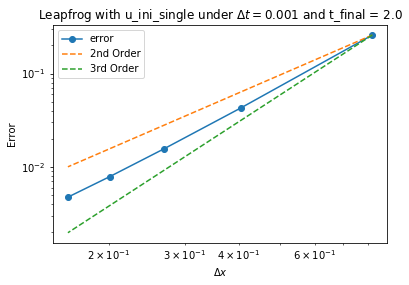

In [171]:
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
error_leap, delta_x = [], []
c_1 = 2.
dt = 0.001
t_final = 2.
t_range = np.arange(0., 1., dt)

for N in [50, 100, 150, 200, 250]:
    U, x, nplt = leap_frog(N, dt, u_ini_single, t_final=t_final)
    
    dx = x[1] - x[0]
    delta_x.append(dx)
    u_true_single = 0.5 * c_1 * (np.cosh(np.sqrt(c_1)*(x+8 - c_1*t_final)/2.))**(-2)
    error_leap.append(np.linalg.norm(dx * (U[-1, :] - u_true_single)))
 
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, error_leap, '-o', label = 'error')
axes.loglog(delta_x, order_C(delta_x[0], error_leap[0], 2.0) * np.array(delta_x)**2.0, '--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error_leap[0], 3.0) * np.array(delta_x)**3.0, '--', label="3rd Order")
axes.legend()
axes.set_xlabel('$ \Delta x$')
axes.set_ylabel('Error')
axes.set_title('Leapfrog with u_ini_single under $ \Delta t = $%s and t_final = %s' %(dt, t_final))
    

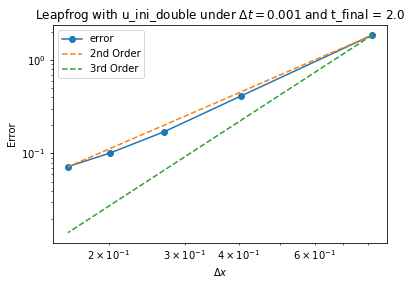

In [166]:
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
error_leap, delta_x = [], []
c_1 = 2.
c_2 = 4
dt = 0.001
t_final = 2.
t_range = np.arange(0., 1., dt)

for N in [50, 100, 150, 200, 250]:
    U, x, nplt = leap_frog(N, dt, u_ini_double, t_final=t_final)
    
    dx = x[1] - x[0]
    delta_x.append(dx)
    u_true_double = 0.5 * c_1 * (np.cosh(np.sqrt(c_1)*(x+8 - c_1 * t_final)/2.))**(-2)
    u_true_double = 0.5*c_1*(np.cosh(np.sqrt(c_1)*(x - c_1*t_final)/2.))**(-2) + 0.5*c_2*(np.cosh(np.sqrt(c_2)*(x+8 - c_2*t_final)/2.))**(-2)

    error_leap.append(np.linalg.norm(dx * (U[-1, :] - u_true_double)))
 
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.loglog(delta_x, error_leap, '-o', label = 'error')
axes.loglog(delta_x, order_C(delta_x[0], error_leap[0], 2.0) * np.array(delta_x)**2.0, '--', label="2nd Order")
axes.loglog(delta_x, order_C(delta_x[0], error_leap[0], 3.0) * np.array(delta_x)**3.0, '--', label="3rd Order")
axes.legend()
axes.set_xlabel('$ \Delta x$')
axes.set_ylabel('Error')
axes.set_title('Leapfrog with u_ini_double under $ \Delta t = $%s and t_final = %s' %(dt, t_final))
    

**Implicit method**

$$
    \frac{1}{\Delta t} (U_j^{n+1} - U_j^n) + \frac{1}{\Delta x} [U_{j+1}^{n+1} (U_j^n + U_{j+1}^n) - U_{j-1}^{n+1}(U_j^n + U_{j-1}^n)] + \frac{1}{2 \Delta x^3} (U_{j+2}^{n+1} - 2 U_{j+1}^{n+1} + 2 U_{j-1}^{n+1} - U_{j-2}^{n+1}) = 0
$$

Separate $U^n$ and $U^{n+1}$

$$
    -\frac{1}{2\Delta x^3} U_{j-2}^{n+1} + (-\frac{1}{\Delta x} (U_j^n + U_{j-1}^n) + \frac{1}{\Delta x^3}) U_{j-1}^{n+1} + \frac{1}{\Delta t} U_j^{n+1} + (\frac{1}{\Delta x} (U_j^n + U_{j+1}^n) - \frac{1}{\Delta x^3}) U_{j+1}^{n+1} + \frac{1}{2\Delta x^3} U_{j+2}^{n+1} = \frac{1}{\Delta t} U_j^n
$$



highly stiff
​
since:

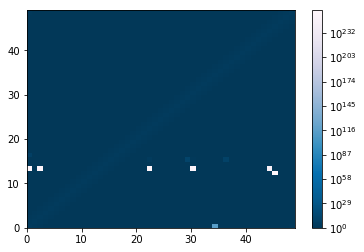

In [14]:
dx = 0.2
dt = 1e-4
x_range = numpy.arange(0, 10, dx)
t_range = numpy.arange(0, 2, dt)
u = np.empty((len(t_range), len(x_range)))
A = numpy.empty((len(x_range), len(x_range)))
i = 1
A[0, 0:3] = numpy.array([1./ dt, 
                         (1. / dx) * (u[i-1, 0] + u[i-1, 1]) - (1. / dx**3), 
                         0.5 / dx**3])
A[0, -2:] = numpy.array([- 0.5 / dx**3, 
                         - (1. / dx) * (u[i-1, 0] + u[i-1, -1]) + (1. / dx**3)])
A[1, 0:4] = numpy.array([- (1. / dx) * (u[i-1, 1] + u[i-1, 0]) + (1. / dx**3), 
                         1./ dt, 
                         (1. / dx) * (u[i-1, 1] + u[i-1, 2]) - (1. / dx**3), 
                         0.5 / dx**3])
A[1, -1] = - 0.5 / dx**3
for j in xrange(2, len(x_range) - 2):
    A[j, j-2:j+3] = numpy.array([- 0.5 / dx**3, 
                                 - (1. / dx) * (u[i-1, j] + u[i-1, j-1]) + (1. / dx**3), 
                                 1./ dt, 
                                 (1. / dx) * (u[i-1, j] + u[i-1, j+1]) - (1. / dx**3), 
                                 0.5 / dx**3])
A[-2, 0] = 0.5 / dx**3
A[-2, -4:] = numpy.array([- 0.5 / dx**3, 
                          - (1. / dx) * (u[i-1, -2] + u[i-1, -3]) + (1. / dx**3), 
                          1./ dt, 
                          (1. / dx) * (u[i-1, -2] + u[i-1, -1]) - (1. / dx**3)])
A[-1, :2] = numpy.array([(1. / dx) * (u[i-1, -1] + u[i-1, 0]) - (1. / dx**3), 
                        0.5 / dx**3])
A[-1, -3:] = numpy.array([- 0.5 / dx**3, 
                          - (1. / dx) * (u[i-1, -1] + u[i-1, -2]) + (1. / dx**3), 
                          1./ dt])

from matplotlib.colors import LogNorm
x = numpy.array(range(50))
y = x.copy()
z = A.reshape(50**2)
X, Y = numpy.meshgrid(x, y)
B = numpy.abs(A)+1
plt.pcolor(X,Y,B, cmap='PuBu_r',norm=LogNorm(vmin=B.min(), vmax=B.max()))
plt.colorbar()



In [15]:
print numpy.abs(numpy.linalg.eigvals(A)).max() / numpy.abs(numpy.linalg.eigvals(A)).min()
print 'Condition number is too big'

3.65650987186e+39
Condition number is too big


**Hopscotch Method**

Suppose $f = \frac{u^2}{2}$

$$
    U^{n+1}_j = U^{n}_j - 3 \frac{\Delta t}{\Delta x}(f^n_{j+1} - f^n_{j-1}) - \frac{\Delta t}{2 (\Delta x)^3} (U^n_{j+2} - 2U^n_{j+1} + 2 U^n_{j-1} - U^n_{j-2})
$$


In [12]:
N = 256
x = np.linspace(-20,20,N)
dx = x[1] - x[0]
c_1 = 2.
u = 0.5 * c_1 * (np.cosh(np.sqrt(c_1)*(x+8)/2.))**(-2)


dt = 0.0001;
t_range = np.arange(0., .01, dt)
n = len(t_range)
m = len(u)

nplt = floor((.01/100)/dt) 
udata = u.transpose()
tdata = 0

c1 = dt/dx
c2 = dt/(dx**3)


U = np.empty((n,m))

U[0,:] = u

figs = []
U[1,0] = 0#U[0,0] - c1*(U[0,1]+ U[0,0] + U[0,-1])*(U[0,1] - U[0,-1]) - c2*0.5*(U[0,2] - 2*U[0,1] + 2.*U[0,-1] - U[0,-2])
U[1,1] = 0#U[0,1] - c1*(U[0,2]+ U[0,1] + U[0,0])*(U[0,2] - U[0,0]) - c2*0.5*(U[0,3] - 2*U[0,2] + 2.*U[0,0] - U[0,-1])
U[1,-1] = U[1,0]
U[1,-2] = U[1,1]
for i in xrange(2,m-2):
    U[1,i] = U[0,i] - 3. * c1*(U[0,i+1]**2 - U[0,i-1]**2) - c2*0.5*(U[0,i+2] - 2*U[0,i+1] + 2.*U[0,i-1] - U[0,i-2])


for i in xrange(len(t_range)):
    if i == 0:
        continue
    U[i, 0] = 0#(U[i-1, 0] - 1. * c1 * (U[i-1, 1]**2 - U[i-1, -1]**2) 
              #- 0.5 * c2 * (U[i-1, 2] - 2. * U[i-1, 1] + 2. * U[i-1, -1] - U[i-1, -2]))
    U[i, 1] = 0#(U[i-1, 1] - 1.5 * c1 * (U[i-1, 2]**2 - U[i-1, 0]**2)  
              #- 0.5 * c2 * (U[i-1, 3] - 2. * U[i-1, 2] + 2. * U[i-1, 0] - U[i-1, -1]))
    U[i, -2] = U[i, 1]
    U[i, -1] = U[i, 0]
    for k in xrange(2, m-2):
        U[i,k] = (U[i-2,k] - 6. * c1 * (U[i-1, k+1]**2 - U[i-1, k-1]**2) 
                  - c2 * (U[i,k+2] - 2. * U[i, k+1] + 2. * U[i, k-1] - U[i, k-2]))

    if i % nplt == 0:
        fig = figure()
        plt.plot(x, U[i,:])
        plt.xlim([-20., 20.])
        plt.ylim([-0.2, 1.1])
        figs.append(fig)
        close(fig)
images = animation_tools.make_images(figs)
animation_tools.JSAnimate_images(images)


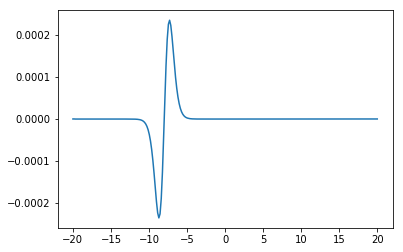

In [31]:
plt.plot(x, U[2,:])

**Hopscotch Method with implicit method**

Suppose $f = \frac{u^2}{2}$

$$
    U^{n+1}_j = U^{n}_j - 3 \frac{\Delta t}{\Delta x}(f^n_{j+1} - f^n_{j-1}) - \frac{\Delta t}{2 (\Delta x)^3} (U^{n+1}_{j+2} - 2U^{n+1}_{j+1} + 2 U^{n+1}_{j-1} - U^{n+1}_{j-2})
$$

$$
    \begin{bmatrix}
    1 & -\frac{\Delta t}{\Delta x^3} & \frac{\Delta t}{2 \Delta x^3} & 0 & \cdots & -\frac{\Delta t}{2 \Delta x^3} & \frac{\Delta t}{\Delta x^3} \\
    \frac{\Delta t}{\Delta x^3} & 1 & -\frac{\Delta t}{\Delta x^3} & \frac{\Delta t}{2\Delta x^3} & \cdots & 0 & -\frac{\Delta t}{2 \Delta x^3} \\
    -\frac{\Delta t}{2 \Delta x^3} & \frac{\Delta t}{\Delta x^3} & 1 & -\frac{\Delta t}{\Delta x^3} & \cdots & 0 & 0 \\
    0 & -\frac{\Delta t}{2 \Delta x^3} & \frac{\Delta t}{\Delta x^3} & 1 & \cdots & 0 & 0 \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    -\frac{\Delta t}{\Delta x^3} & \frac{\Delta t}{2 \Delta x^3} & 0 & 0 & \cdots & \frac{\Delta t}{\Delta x^3} & 1
    \end{bmatrix} \mathbf{U^{n+1}} = \mathbf{U^{n}} - \frac{3\Delta t}{\Delta x} 
    \begin{bmatrix}
    0 & 1 & 0 & \cdots & 0 & 1 \\
    1 & 0 & 1 & \cdots & 0 & 0 \\
    0 & 1 & 0 & \cdots & 0 & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    0 & 0 & 0 & \cdots & 0 & 1 \\
    1 & 0 & 0 & \cdots & 1 & 0
    \end{bmatrix} \mathbf{f^{n}}
$$

In [19]:
dx = 0.2
dt = 1e-5
x_range = numpy.arange(0, 10, dx)
t_range = numpy.arange(0, 2, dt)
figs = []
u = u_ini(x_range)
diag = numpy.ones(len(x_range))
A = numpy.identity(len(x_range)) - (dt / dx**3) * numpy.diag(diag[1:], 1) + 2. * (dt / dx**3) * numpy.diag(diag[2:], 2)
A = A + (dt / dx**3) * numpy.diag(diag[1:], -1) - 2. * (dt / dx**3) * numpy.diag(diag[2:], -2)
A[0, -2] =  - 2. * (dt / dx**3)
A[0, -1] = (dt / dx**3)
A[1, -1] = - 2. * (dt / dx**3)
A[-2, 0] = 2. * (dt / dx**3)
A[-1, 0] = - (dt / dx**3)
A[-1, 1] = 2. * (dt / dx**3)

for i in xrange(len(t_range)):
    F = numpy.empty(len(x_range))
    F[1:-1] = u[2:]**2 - u[:-2]**2
    F[0] = u[1] - u[-1]
    F[-1] = u[0] - u[-2]
    
    B = u + 1.5 * dt / dx * F
    
    u = numpy.linalg.solve(A, B)
    if i % 1000 == 0:
        fig = figure()
        plt.plot(x_range, u)
        plt.ylim([-0.5, 1.5])
    #     plt.xlim([1., 7.])
        figs.append(fig)
        close(fig)
    
images = animation_tools.make_images(figs)
animation_tools.JSAnimate_images(images)

KeyboardInterrupt: 